In [ ]:
pip install pyspark

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=727ec8e5cfd10a9f5c10a3661d22fce4c429390499b70238f16f03e6c888145f
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, translate
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from scipy import stats
spark = SparkSession.builder.master("local[2]").appName("Youtube videos like perdiction").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [ ]:
df_spark = sqlContext.read.csv("USvideos.csv", header=True, inferSchema = True)
df_spark.count()

44261

In [ ]:
df_spark.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- video_error_or_removed: string (nullable = true)
 |-- description: string (nullable = true)



In [ ]:
df_spark.show(10)

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|                tags|  views| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|2kyS6SvSYSE|     17.14.11|WE WANT TO TALK A...|        CaseyNeistat|         22|2017-11-13T17:13:...|     SHANtell martin| 748374| 57527|    2966|        15954|https://i.ytimg.c...|            False|           Fal

In [ ]:
df_spark.select('channel_title').distinct().rdd.map(lambda r: r[0]).collect()

['90s Commercials',
 'David Jardine',
 'The New York Times',
 'National Safety Council',
 'SPORTSNET',
 'Paul Sellers',
 'NBC',
 'AnselElgortVEVO',
 'Any rubbish',
 'Mikey Murphy',
 'Rudy Mancuso',
 'Mayo Clinic',
 'Apple Support',
 'kmichelle',
 'Car Commercials of the Past',
 'Pittsburgh Dad',
 ' and a few that no one knows about! Make sure you say hello and hit the subscribe button',
 'Today I Found Out',
 'DoodleChaos',
 'danisnotinteresting',
 '494ta',
 'Shawn',
 'EvanescenceVEVO',
 'Nickelback',
 'ImagineDragonsVEVO',
 'AlishaMarie',
 'Guy Tang',
 'Townsends',
 'Symon',
 'Gemma Stafford',
 'King Princess',
 'Braille Skateboarding',
 'ESPN UK',
 'OmarGoshTV',
 'Danny Sapko',
 'BBC Radio 1',
 'Clevver News',
 "Victoria's Secret",
 'Awkward Puppets',
 'Despierta América',
 'Peter Brown',
 'fuzywazacolin',
 'reputationswift',
 'Rainsford',
 'The CW Television Network',
 'Penguin Books UK',
 'Kyle Gunderson',
 'Lucas',
 'F Milburn',
 "What I've Learned",
 'samfryltd',
 'StarTalk',
 'F

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
US_video = pd.read_csv("USvideos.csv")# just for visualization purposes

In [ ]:
print(US_video["publish_time"].value_counts())
US_video["publish_time"]=pd.to_datetime(US_video["publish_time"])

2018-05-18T14:00:04.000Z    50
2018-05-06T13:00:05.000Z    32
2018-05-13T18:03:56.000Z    30
2018-05-14T19:00:01.000Z    29
2018-05-14T13:00:01.000Z    29
                            ..
2018-01-27T02:46:21.000Z     1
2018-01-05T19:00:06.000Z     1
2017-12-14T16:00:11.000Z     1
2018-03-12T20:37:44.000Z     1
2017-12-12T11:00:04.000Z     1
Name: publish_time, Length: 6269, dtype: int64


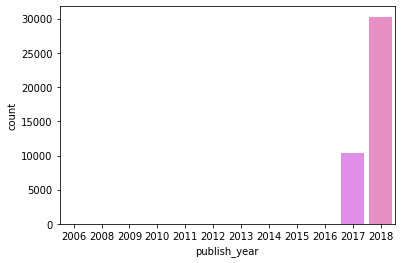

In [ ]:
US_video=US_video.assign(publish_day=US_video.publish_time.dt.day,publish_month=US_video.publish_time.dt.month,publish_year=US_video.publish_time.dt.year)
sns.countplot(x=US_video["publish_year"],data=US_video)

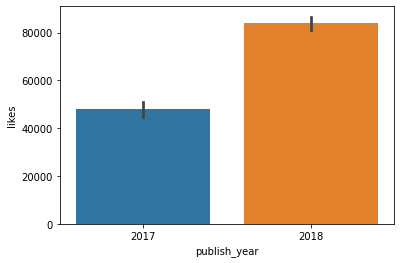

In [ ]:
US_video.drop(US_video[US_video["publish_year"]<2017].index,inplace=True)
sns.barplot(x=US_video["publish_year"],y=US_video["likes"])


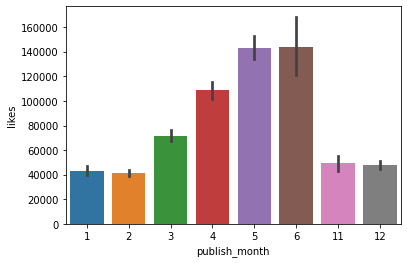

In [ ]:
sns.countplot(x=US_video["publish_month"],data=US_video)
US_video.drop(US_video[(US_video["publish_month"]<11) & (US_video["publish_month"]>7)].index,inplace=True)
sns.barplot(x=US_video["publish_month"],y=US_video["likes"])

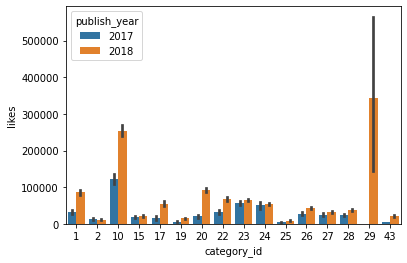

In [ ]:
sns.barplot(x=US_video["category_id"],y=US_video["likes"],data=US_video,hue="publish_year")

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


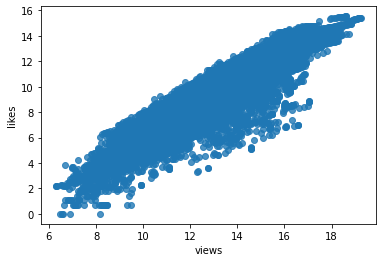

In [ ]:
import numpy as np
x1=np.log(US_video["views"])
y1=np.log(US_video["likes"])
sns.regplot(x=x1,y=y1,fit_reg=False)

In [ ]:
df_spark.select('title', 'likes').show()

+--------------------+------+
|               title| likes|
+--------------------+------+
|WE WANT TO TALK A...| 57527|
|The Trump Preside...| 97185|
|Racist Superman |...|146033|
|Nickelback Lyrics...| 10172|
|I Dare You: GOING...|132235|
|2 Weeks with iPho...|  9763|
|Roy Moore & Jeff ...| 15993|
|5 Ice Cream Gadge...| 23663|
|The Greatest Show...|  3543|
|Why the rise of t...| 12654|
|Dion Lewis' 103-Y...|   655|
|(SPOILERS) 'Shiva...|  1576|
|Marshmello - Bloc...|114188|
|Which Countries A...|  7848|
|SHOPPING FOR NEW ...|  7473|
|    The New SpotMini|  9419|
|One Change That W...|  8011|
|How does your bod...|  5398|
|HomeMade Electric...| 11963|
|Founding An Inbre...|  8421|
+--------------------+------+
only showing top 20 rows



In [ ]:
df_spark = df_spark.withColumn("category_id", df_spark["category_id"].cast(IntegerType()))
df_spark = df_spark.withColumn("views", df_spark["views"].cast(IntegerType()))
df_spark = df_spark.withColumn("dislikes", df_spark["dislikes"].cast(IntegerType()))
df_spark = df_spark.withColumn("likes", df_spark["likes"].cast(IntegerType()))

In [ ]:
featureCols = ['category_id','views' , "dislikes"]

In [ ]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [ ]:
df1 = assembler.transform(df_spark)
df1 = df1.select(['features', 'likes'])
df1.show()

+--------------------+------+
|            features| likes|
+--------------------+------+
|[22.0,748374.0,29...| 57527|
|[24.0,2418783.0,6...| 97185|
|[23.0,3191434.0,5...|146033|
|[24.0,343168.0,66...| 10172|
|[24.0,2095731.0,1...|132235|
|[28.0,119180.0,51...|  9763|
|[24.0,2103417.0,2...| 15993|
|[28.0,817732.0,77...| 23663|
|[1.0,826059.0,119.0]|  3543|
|[25.0,256426.0,13...| 12654|
| [17.0,81377.0,25.0]|   655|
|[24.0,104578.0,30...|  1576|
|[10.0,687582.0,13...|114188|
|[25.0,544770.0,11...|  7848|
|[15.0,207532.0,24...|  7473|
| [28.0,75752.0,52.0]|  9419|
|[23.0,295639.0,63...|  8011|
| [27.0,78044.0,53.0]|  5398|
| [28.0,97007.0,36.0]| 11963|
|[27.0,223871.0,19...|  8421|
+--------------------+------+
only showing top 20 rows



In [ ]:
splits = vhouse_df.randomSplit([0.9, 0.1])
train_df = splits[0]
test_df = splits[1]

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'likes')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="likes", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error testdata = %g" % rmse)

Root Mean Squared Error testdata = 0.412311
